<a href="https://colab.research.google.com/github/ldocarvalho/portals-bias/blob/main/portals_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data

In [48]:
import pandas as pd

In [49]:
df_names = ["Source","Title","Content","Bias"]
df_news_aggregator = pd.read_csv('https://raw.githubusercontent.com/ldocarvalho/portals-bias/main/Dataset/News-Aggregator-14/news-aggregator.csv?token=AKX52J7EV5Y2TFAPAPLJ3Q3BYDMV2', names = df_names, skiprows = 1, header = None)
df_news_aggregator

,Source,Title,Content,Bias
0,wsj.com,"EU Week Ahead March 10-14: Bank Resolution, Tr...",The European Union’s to-do list isn’t long thi...,right-center
1,wsj.com,ECB's Noyer not Happy With Euro Strength -- Up...,News Corp is a network of leading companies in...,right-center
2,seattlepi.com,"EBay, Icahn talk smack",Follow @csaid EBay has come out swinging again...,left-center
3,techcrunch.com,EBay Asks Shareholders To Vote Against PayPal ...,The war of words between eBay and its new shar...,left-center
4,valuewalk.com,Carl Icahn: Donahoe Cost eBay Investors More T...,Carl Icahn has again posted an open letter on ...,right-center
...,...,...,...,...
1795,newsone.com,NewsOne Minute: Chris Rock Interviews White Pe...,Chris Rock Interviews White People at a Monste...,left-center
1796,twitchy.com,Chart-topping songwriter Diane Warren: Hope so...,Texas cheerleader and big-game hunter Kendall ...,right
1797,twitchy.com,Reality star Joanna Krupa would love to see ‘t...,Model Joanna Krupa is known for her stints on ...,right
1798,austinchronicle.com,Elaine Stritch (1925-2014),"During her seven decades as a ""Broadway Baby"" ...",left


In [50]:
df_news_july = pd.read_csv('https://raw.githubusercontent.com/ldocarvalho/portals-bias/main/Dataset/News-July-19/news-july.csv?token=AKX52J5KQ3NIC6K7PWM7XPLBYDNKA', names = df_names, skiprows = 1, header = None)
df_news_july

,Source,Title,Content,Bias
0,berkeleyside,"ArchivesJune 10, 2019",When the homeowner did not voluntarily repair ...,left-center
1,berkeleyside,Berkeley homeowner caught in costly code viola...,"Finger-pointing, confusion, worry and mistrust...",left-center
2,berkeleyside,"A small-business success story, Yalis Caf cele...","Yali's Caf 1920 Oxford St. (at Berkeley Way), ...",left-center
3,berkeleyside,Shop Talk: Bluemercury; Airport Home Appliance...,BLUEMERCURY A new business is opening in the o...,left-center
4,berkeleyside,New vision plan imagines 3-mile greenway from ...,Imagine a bike and pedestrian path stretching ...,left-center
...,...,...,...,...
4955,theblaze,Bill Cosbys official Instagram account shares ...,The official Instagram account of actor Bill C...,right
4956,theblaze,WATCH: Students condemn racist remarks they be...,Students at Marymount University in Virginia b...,right
4957,theblaze,Republicans propose constitutional amendment t...,President Donald Trump is supporting a propose...,right
4958,theblaze,108 GOP lawmakers sign letter asking Trump to ...,More than a hundred Republican members of Cong...,right


In [51]:
df_news_february = pd.read_csv('https://raw.githubusercontent.com/vicaires/News-Media-Bias-Datasets/main/Text-based%20datasets/News-February-20/news-february.csv', names = df_names, skiprows = 1, header = None)
df_news_february

,Source,Title,Content,Bias
0,motherjones.com,Terms of Service,Welcome to the Mother Jones website. Please re...,left-center
1,motherjones.com,The Enormous but Hidden Consequences of Antarc...,This story was originally published by Wired a...,left-center
2,motherjones.com,Mother Jones Logo (Orange) Women's Fitted Tee,motherjones-logoorange-wtee-white-sm $20.00 Mo...,left-center
3,motherjones.com,A Fucking Disaster That Is Designed to Fail: H...,"SAN DIEGO IMMIGRATION COURT, COURTROOM #2; PRE...",left-center
4,motherjones.com,Privacy Policy,The MotherJones.com website is operated by the...,left-center
...,...,...,...,...
11515,punchingbagpost.com,"Trump Reverses Obama, Hands Farmers, Landowner...","tml> Trump Reverses Obama, Hands Farmers, Land...",right-center
11516,punchingbagpost.com,Russia Germany Dispute Could Trigger Trade War,You Might Like German lawmakers are calling to...,right-center
11517,punchingbagpost.com,Bloomberg is Still Trying to Buy the Election ...,"In less than three months, Democratic presiden...",right-center
11518,punchingbagpost.com,Everything China Told us About the Coronavirus...,"For weeks, officials throughout the world assu...",right-center


### 2. Text Pre-processing

In [52]:
def to_lower(text):
  return text.lower()

In [53]:
import re

def remove_numbers(text):
  return re.sub(r'\d+', '', text)

In [54]:
import string
import numpy as np

def remove_puctuation(text):
  symbols = "!\"#$%&()'*+-.,—/:;<=>?@[\]^_`{|}~\n“‘"
  for i in symbols:
    text = text.replace(i, '')
  return text

In [55]:
def preprocess(data):
    data = to_lower(data)
    data = remove_puctuation(data)
    data = remove_numbers(data)
    return data

### 3. Readability

#### Utils

In [56]:
pip install textstat

In [57]:
import spacy
from textstat.textstat import textstatistics, legacy_round

def break_sentences(text):
	nlp = spacy.load('en_core_web_sm')
	doc = nlp(text)
	return list(doc.sents)

def word_count(text):
	sentences = break_sentences(text)
	words = 0
	for sentence in sentences:
		words += len([token for token in sentence])
	return words

def sentence_count(text):
	sentences = break_sentences(text)
	return len(sentences)

def avg_sentence_length(text):
	words = word_count(text)
	sentences = sentence_count(text)
	average_sentence_length = float(words / sentences)
	return average_sentence_length

def syllables_count(word):
	return textstatistics().syllable_count(word)

def avg_syllables_per_word(text):
	syllable = syllables_count(text)
	words = word_count(text)
	ASPW = float(syllable) / float(words)
	return legacy_round(ASPW, 1)

def difficult_words(text):
	nlp = spacy.load('en_core_web_sm')
	doc = nlp(text)

	words = []
	sentences = break_sentences(text)
	for sentence in sentences:
		words += [str(token) for token in sentence]

	diff_words_set = set()
	
	for word in words:
		syllable_count = syllables_count(word)
		if word not in nlp.Defaults.stop_words and syllable_count >= 2:
			diff_words_set.add(word)

	return len(diff_words_set)

def poly_syllable_count(text):
	count = 0
	words = []
	sentences = break_sentences(text)
	for sentence in sentences:
		words += [token for token in sentence]
	

	for word in words:
		syllable_count = syllables_count(word)
		if syllable_count >= 3:
			count += 1
	return count

#### Flesch-Kincaid

In [58]:
def flesch_reading_ease(text):
	FRE = 206.835 - float(1.015 * avg_sentence_length(text)) -\
		float(84.6 * avg_syllables_per_word(text))
	return legacy_round(FRE, 2)

#### Dale-Chall

In [59]:
def dale_chall_readability_score(text):
  words = word_count(text)
  difficult_words_count = difficult_words(text)
  count = words - difficult_words_count
  
  if words > 0:
    per = float(count) / float(words) * 100
  
  diff_words = 100 - per
  raw_score = (0.1579 * diff_words) + (0.0496 * avg_sentence_length(text))
  
  if diff_words > 5:	
    raw_score += 3.6365
  
  return legacy_round(raw_score, 2)

#### Gunning Fog

In [60]:
def gunning_fog_score(text):
	per_diff_words = ((difficult_words(text) / word_count(text)) * 100) + 5
	grade = 0.4 * (avg_sentence_length(text) + per_diff_words)
	return grade

#### SMOG

In [61]:
def smog_index(text):
	if sentence_count(text) >= 3:
		poly_syllab = poly_syllable_count(text)
		SMOG = (1.043 * (30*(poly_syllab / sentence_count(text)))**0.5) \
				+ 3.1291
		return legacy_round(SMOG, 1)
	else:
		return 0

#### News July - Readability Features

In [62]:
df_readability_names = ["flesch-kincaid", "flesch-reading-ease", "dale-chall", "gunning-fog", "bias"]
df_readability = pd.DataFrame(columns = df_readability_names)
df_readability

,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog,bias


In [63]:
import textstat

for value in df_news_july.values:
  bias = ""
  if "left" in value[3]:
    bias = "left"
  else:
    bias = "right"
  content = preprocess(value[2])
  flesch_kincaid = textstat.flesch_kincaid_grade(content)
  flesch_reading = textstat.flesch_reading_ease(content)
  dale_chall = textstat.dale_chall_readability_score(content)
  gunning_fog = textstat.gunning_fog(content)
  df_readability = df_readability.append({"flesch-kincaid": flesch_kincaid, "flesch-reading-ease": flesch_reading, "dale-chall": dale_chall, "gunning-fog": gunning_fog, "bias": bias}, ignore_index=True)
df_readability

,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog,bias
0,15.0,35.61,9.07,18.21,left
1,1038.0,-2615.91,138.35,1064.84,left
2,495.5,-1198.63,69.56,509.25,left
3,458.4,-1107.62,65.46,470.74,left
4,737.7,-1834.36,100.65,757.69,left
...,...,...,...,...,...
4955,119.9,-226.60,22.80,124.11,right
4956,135.5,-267.20,24.15,139.61,right
4957,110.2,-206.64,21.09,113.10,right
4958,119.9,-232.02,22.80,122.94,right


In [64]:
y = df_readability['bias']

In [65]:
pip install -U scikit-learn

In [76]:
from numpy import mean
from numpy import std

from sklearn import preprocessing
from sklearn.svm import SVC

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_with_svm(X, gamma, c, k):
  original_class = []
  predicted_class = []

  def classification_report_with_accuracy(y_true, y_pred):
    original_class.extend(y_true)
    predicted_class.extend(y_pred)
    return accuracy_score(y_true, y_pred) 

  model = SVC(kernel='rbf', gamma=gamma, C=c)
  score = cross_val_score(model, X = X, y = y, cv = k, scoring = make_scorer(classification_report_with_accuracy))

  print(classification_report(original_class, predicted_class))

  labels_class = ['Esquerda', 'Direita']
  data = confusion_matrix(original_class, predicted_class, normalize='true')
  df_cm = pd.DataFrame(data, columns=labels_class, index=labels_class)
  df_cm.index.name = 'Real'
  df_cm.columns.name = 'Predito'
  plt.figure(figsize = (7,5))
  sns.set(font_scale=1.0)
  sns.heatmap(df_cm, annot=True, cmap='coolwarm', fmt=".2f")
  plt.plot()

In [110]:
def grid_search_cv_with_svm(X):
  model = GridSearchCV(SVC(kernel='rbf'), {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['auto', 'scale'],
  }, cv=10, n_jobs=-1)

  model.fit(X, y)
  df_results = pd.DataFrame(model.cv_results_)
  print(df_results[['param_C', 'param_gamma', 'mean_test_score']])

##### 1 feature

###### Flesch-Kincaid

In [108]:
X_1 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'gunning-fog', 'bias'], axis=1)

In [111]:
grid_search_cv_with_svm(X_1)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.509073
1    0.01       scale         0.540726
2     0.1        auto         0.516331
3     0.1       scale         0.537903
4       1        auto         0.517944
5       1       scale         0.536492
6      10        auto         0.516331
7      10       scale         0.533669
8     100        auto         0.509274
9     100       scale         0.528831


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.57      0.33      0.42      2480
       right       0.53      0.75      0.62      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



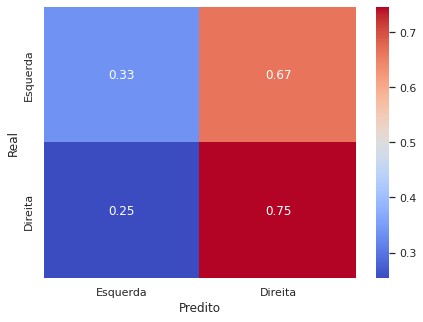

In [75]:
classification_with_svm(X_1, 'scale', 0.01, 10)

###### Flesch reading ease

In [79]:
X_2 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'gunning-fog', 'bias'], axis=1)

In [112]:
grid_search_cv_with_svm(X_2)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.522379
1    0.01       scale         0.541331
2     0.1        auto         0.522379
3     0.1       scale         0.537500
4       1        auto         0.530847
5       1       scale         0.535484
6      10        auto         0.518750
7      10       scale         0.535282
8     100        auto         0.508266
9     100       scale         0.530645


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.57      0.34      0.42      2480
       right       0.53      0.75      0.62      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



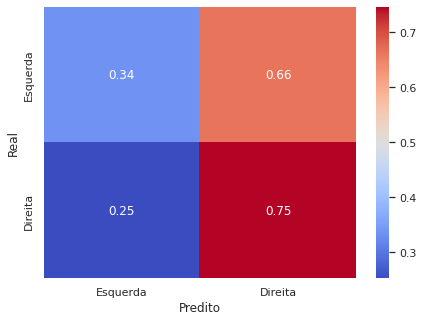

In [80]:
classification_with_svm(X_2, 'scale', 0.01, 10)

###### Dale-Chall 

In [81]:
X_3 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'gunning-fog', 'bias'], axis=1)

In [113]:
grid_search_cv_with_svm(X_3)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.522984
1    0.01       scale         0.541532
2     0.1        auto         0.511492
3     0.1       scale         0.538105
4       1        auto         0.522581
5       1       scale         0.534879
6      10        auto         0.521774
7      10       scale         0.535685
8     100        auto         0.528831
9     100       scale         0.530847


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.57      0.33      0.42      2480
       right       0.53      0.75      0.62      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



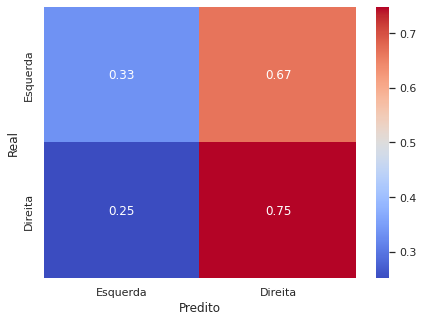

In [82]:
classification_with_svm(X_3, 'scale', 0.01, 10)

###### Gunning fog

In [83]:
X_4 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'dale-chall', 'bias'], axis=1)

In [114]:
grid_search_cv_with_svm(X_4)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.521976
1    0.01       scale         0.540323
2     0.1        auto         0.524194
3     0.1       scale         0.537903
4       1        auto         0.519556
5       1       scale         0.535685
6      10        auto         0.523185
7      10       scale         0.533468
8     100        auto         0.524395
9     100       scale         0.530645


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.57      0.33      0.42      2480
       right       0.53      0.75      0.62      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



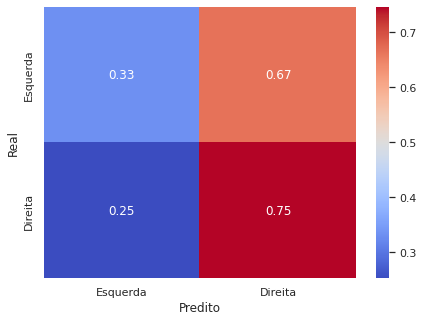

In [84]:
classification_with_svm(X_4, 'scale', 0.01, 10)

##### 2 features

###### Flesch-Kincaid + Flesch reading ease

In [85]:
X_12 = df_readability.drop(['dale-chall', 'gunning-fog', 'bias'], axis=1)

In [115]:
grid_search_cv_with_svm(X_12)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.512097
1    0.01       scale         0.543548
2     0.1        auto         0.512097
3     0.1       scale         0.538911
4       1        auto         0.520161
5       1       scale         0.536895
6      10        auto         0.513508
7      10       scale         0.536290
8     100        auto         0.513508
9     100       scale         0.535484


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.58      0.31      0.40      2480
       right       0.53      0.78      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.56      0.54      0.52      4960
weighted avg       0.56      0.54      0.52      4960



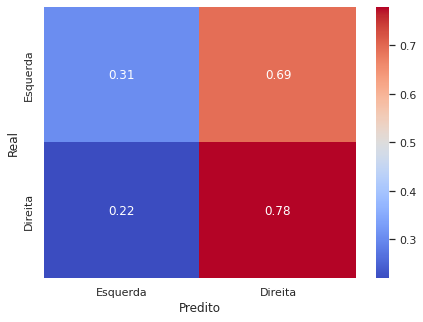

In [86]:
classification_with_svm(X_12, 'scale', 0.01, 10)

###### Flesch-Kincaid + Dale-Chall

In [87]:
X_13 = df_readability.drop(['flesch-reading-ease', 'gunning-fog', 'bias'], axis=1)

In [116]:
grid_search_cv_with_svm(X_13)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.516331
1    0.01       scale         0.542742
2     0.1        auto         0.526613
3     0.1       scale         0.540726
4       1        auto         0.513105
5       1       scale         0.536290
6      10        auto         0.509476
7      10       scale         0.535282
8     100        auto         0.497984
9     100       scale         0.532661


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.58      0.32      0.41      2480
       right       0.53      0.77      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



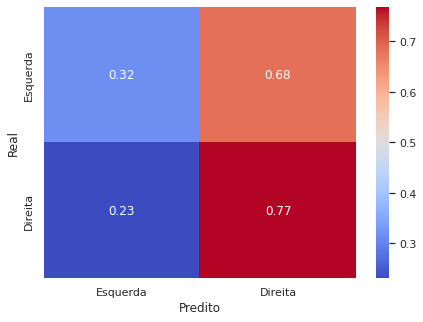

In [88]:
classification_with_svm(X_13, 'scale', 0.01, 10)

###### Flesch-Kincaid + Gunning fog

In [89]:
X_14 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'bias'], axis=1)

In [117]:
grid_search_cv_with_svm(X_14)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.507460
1    0.01       scale         0.540726
2     0.1        auto         0.507258
3     0.1       scale         0.538105
4       1        auto         0.505444
5       1       scale         0.536290
6      10        auto         0.513306
7      10       scale         0.533468
8     100        auto         0.509677
9     100       scale         0.529839


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.57      0.33      0.42      2480
       right       0.53      0.75      0.62      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



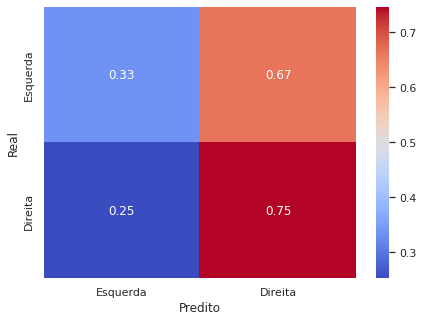

In [90]:
classification_with_svm(X_14, 'scale', 0.01, 10)

###### Flesch reading ease + Dale-Chall

In [91]:
X_23 = df_readability.drop(['flesch-kincaid', 'gunning-fog', 'bias'], axis=1)

In [118]:
grid_search_cv_with_svm(X_23)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.526815
1    0.01       scale         0.542339
2     0.1        auto         0.526815
3     0.1       scale         0.541935
4       1        auto         0.535685
5       1       scale         0.535685
6      10        auto         0.522379
7      10       scale         0.534879
8     100        auto         0.503427
9     100       scale         0.532661


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.58      0.31      0.41      2480
       right       0.53      0.77      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



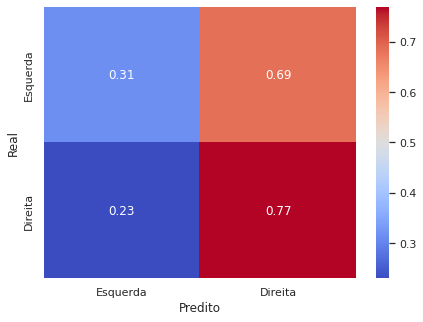

In [92]:
classification_with_svm(X_23, 'scale', 0.01, 10)

###### Flesch reading ease + Gunning fog

In [93]:
X_24 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'bias'], axis=1)

In [119]:
grid_search_cv_with_svm(X_24)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.507863
1    0.01       scale         0.543548
2     0.1        auto         0.507863
3     0.1       scale         0.538710
4       1        auto         0.523589
5       1       scale         0.536895
6      10        auto         0.521976
7      10       scale         0.536290
8     100        auto         0.517944
9     100       scale         0.535484


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.58      0.31      0.40      2480
       right       0.53      0.78      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.56      0.54      0.52      4960
weighted avg       0.56      0.54      0.52      4960



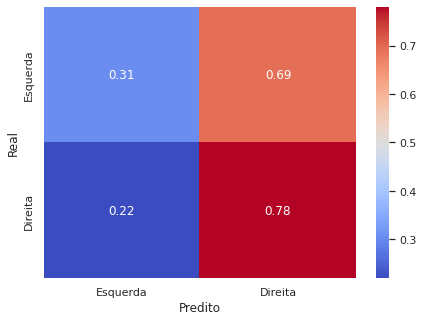

In [94]:
classification_with_svm(X_24, 'scale', 0.01, 10)

###### Dale-Chall + Gunning fog

In [95]:
X_34 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'bias'], axis=1)

In [120]:
grid_search_cv_with_svm(X_34)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.525000
1    0.01       scale         0.543145
2     0.1        auto         0.524395
3     0.1       scale         0.540524
4       1        auto         0.529032
5       1       scale         0.536290
6      10        auto         0.527419
7      10       scale         0.535081
8     100        auto         0.528226
9     100       scale         0.533065


              precision    recall  f1-score   support

        left       0.58      0.32      0.41      2480
       right       0.53      0.77      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



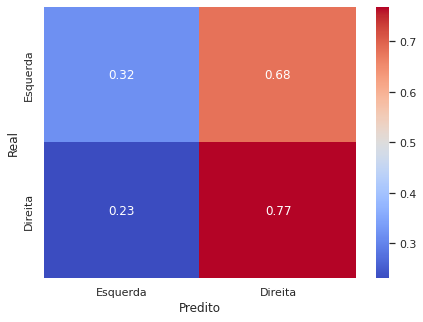

In [96]:
classification_with_svm(X_34, 'scale', 0.01, 10)

##### 3 features

###### Flesch-Kincaid + Flesch reading ease + Dale-Chall
 

In [99]:
X_123 = df_readability.drop(['gunning-fog', 'bias'], axis=1)

In [121]:
grid_search_cv_with_svm(X_123)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.516935
1    0.01       scale         0.544355
2     0.1        auto         0.516935
3     0.1       scale         0.538508
4       1        auto         0.525202
5       1       scale         0.536694
6      10        auto         0.516532
7      10       scale         0.537298
8     100        auto         0.507863
9     100       scale         0.534677


              precision    recall  f1-score   support

        left       0.58      0.31      0.40      2480
       right       0.53      0.78      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.56      0.54      0.52      4960
weighted avg       0.56      0.54      0.52      4960



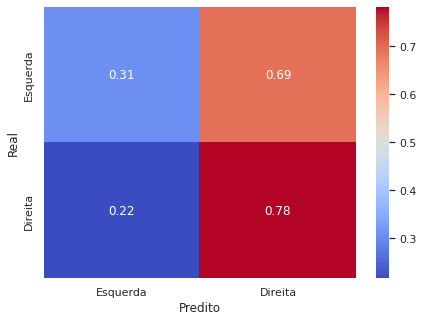

In [100]:
classification_with_svm(X_123, 'scale', 0.01, 10)

###### Flesch-Kincaid + Flesch reading ease + Gunning fog

In [101]:
X_124 = df_readability.drop(['dale-chall', 'bias'], axis=1)

In [122]:
grid_search_cv_with_svm(X_124)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.507258
1    0.01       scale         0.544153
2     0.1        auto         0.507258
3     0.1       scale         0.538105
4       1        auto         0.527419
5       1       scale         0.537097
6      10        auto         0.517944
7      10       scale         0.537097
8     100        auto         0.517944
9     100       scale         0.536089


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.59      0.30      0.40      2480
       right       0.53      0.79      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.56      0.54      0.52      4960
weighted avg       0.56      0.54      0.52      4960



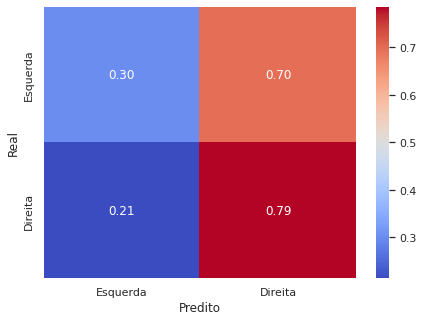

In [102]:
classification_with_svm(X_124, 'scale', 0.01, 10)

###### Flesch-Kincaid  + Dale-Chall + Gunning fog

In [103]:
X_134 = df_readability.drop(['flesch-reading-ease', 'bias'], axis=1)

In [123]:
grid_search_cv_with_svm(X_134)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.518548
1    0.01       scale         0.541734
2     0.1        auto         0.519355
3     0.1       scale         0.539919
4       1        auto         0.509879
5       1       scale         0.535685
6      10        auto         0.514516
7      10       scale         0.534677
8     100        auto         0.507863
9     100       scale         0.532460


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.58      0.32      0.41      2480
       right       0.53      0.76      0.62      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



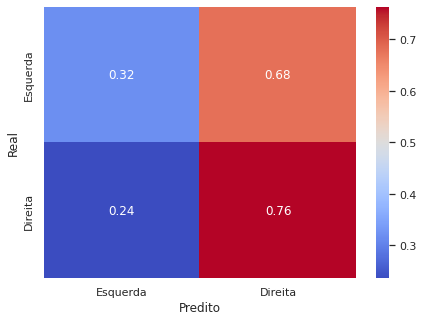

In [104]:
classification_with_svm(X_134, 'scale', 0.01, 10)

###### Flesch reading ease + Dale-Chall + Gunning fog

In [105]:
X_234 = df_readability.drop(['flesch-kincaid', 'bias'], axis=1)

In [124]:
grid_search_cv_with_svm(X_234)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.513306
1    0.01       scale         0.544758
2     0.1        auto         0.513306
3     0.1       scale         0.538306
4       1        auto         0.528831
5       1       scale         0.536694
6      10        auto         0.520968
7      10       scale         0.536895
8     100        auto         0.519355
9     100       scale         0.534476


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.59      0.31      0.40      2480
       right       0.53      0.78      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.56      0.54      0.52      4960
weighted avg       0.56      0.54      0.52      4960



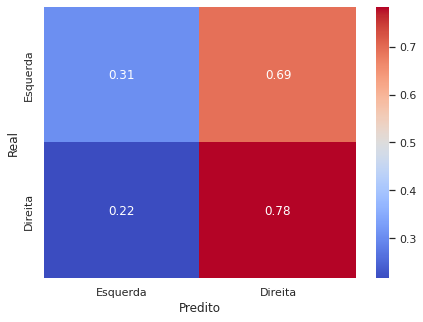

In [106]:
classification_with_svm(X_234, 'scale', 0.01, 10)

##### 4 features

In [97]:
X_1234 = df_readability.drop(['bias'], axis=1)

In [125]:
grid_search_cv_with_svm(X_1234)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.515121
1    0.01       scale         0.544355
2     0.1        auto         0.515121
3     0.1       scale         0.538306
4       1        auto         0.528427
5       1       scale         0.537097
6      10        auto         0.515323
7      10       scale         0.536895
8     100        auto         0.512097
9     100       scale         0.534879


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.59      0.30      0.40      2480
       right       0.53      0.79      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.56      0.54      0.52      4960
weighted avg       0.56      0.54      0.52      4960



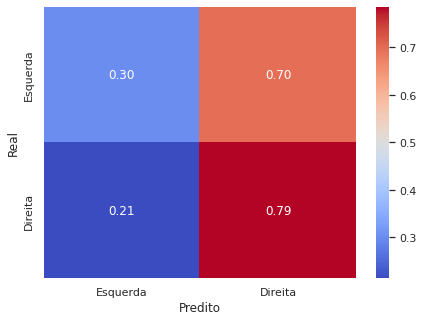

In [98]:
classification_with_svm(X_1234, 'scale', 0.01, 10)

### 5. Information Theory Approach to detect media bias

#### Testes News July

##### 5.1.3.1. Computar importância de todos os termos e descartar os de menor frequência

In [ ]:
corpus_news_aggregator_left = ""
corpus_news_aggregator_right = ""

for index, row in df_news_july.iterrows():
    text = row['Content']
    if 'left' in row['Bias']:
        corpus_news_aggregator_left += preprocess(text)
    else: 
        corpus_news_aggregator_right += preprocess(text)

In [ ]:
bag_of_words_news_aggregator_left = corpus_news_aggregator_left.split(' ')

In [ ]:
bag_of_words_news_aggregator_right = corpus_news_aggregator_right.split(' ')

In [ ]:
bag_of_words = set(bag_of_words_news_aggregator_left).union(set(bag_of_words_news_aggregator_right))

In [ ]:
number_of_words_left = dict.fromkeys(bag_of_words, 0)
for word in bag_of_words_news_aggregator_left:
    number_of_words_left[word] += 1
df_left = pd.DataFrame(list(number_of_words_left.items()),columns = ['word','occ-left'])

number_of_words_right = dict.fromkeys(bag_of_words, 0)
for word in bag_of_words_news_aggregator_right:
    number_of_words_right[word] += 1
df_right = pd.DataFrame(list(number_of_words_right.items()),columns = ['word','occ-right'])

df_words = pd.merge(df_left, df_right, on='word')
df_words

In [ ]:
index = df_words[ df_words['occ-left'] + df_words['occ-right'] < 10 ].index
df_words.drop(index, inplace = True)
df_words

##### 5.1.3.2. Construção da função de probabilidade do termo t sobre as classes

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

df_words['perc-left'] = 0.0
df_words['perc-right'] = 0.0

for i in df_words.index:
  total = df_words['occ-left'][i] + df_words['occ-right'][i]
  df_words['perc-left'][i] = round(float(df_words['occ-left'][i] / total), 3)
  df_words['perc-right'][i] = round(float(df_words['occ-right'][i] / total), 3)

df_words

##### 5.1.3.3. Calcular a entropia de cada termo

In [ ]:
df_words['shannon-entropy'] = 0.0
df_words

In [ ]:
import numpy
import sys
numpy.seterr(divide = 'warn') 

def calculate_shannon_entropy(probs):
  sum = 0.0
  for prob in probs:
    if prob != 0:
      sum -= prob * numpy.log(prob)
  return sum / numpy.log(2)

In [ ]:
df_words['shannon-entropy'] = 0.0

for i in df_words.index:
  shannon_entropy = round(calculate_shannon_entropy([df_words['perc-left'][i], df_words['perc-right'][i]]), 3)
  df_words['shannon-entropy'][i] = shannon_entropy

df_words

In [ ]:
df_trump = df_words.loc[df_words['word'] == 'trump']
df_trump

In [ ]:
df_soros = df_words.loc[df_words['word'] == 'soros']
df_soros

##### 5.1.3.4. Selecionar vocabulário de referência

In [ ]:
df_reference_vocabulary = df_words.nsmallest(10000, ['shannon-entropy'])
df_reference_vocabulary

##### 5.1.4 Modelagem da função de probabilidade de todos os termos t ∈ VR

In [ ]:
df_news_july

In [ ]:
df_portals_content_names = ["Source", "Content", "Bias"]
df_portals_content = pd.DataFrame(columns = df_portals_content_names)
df_portals_content

In [ ]:
last_source = "berkeleyside"
df_portals_content = df_portals_content.append({'Source': last_source, 'Content': "", "Bias": "left"}, ignore_index=True)

for index, row in df_news_july.iterrows():
  source = row['Source']
  bias = ""
  if "left" in row['Bias']:
    bias = "left"
  else:
    bias = "right"
  if source != last_source:
    df_portals_content = df_portals_content.append({'Source': source, 'Content': "", "Bias": bias}, ignore_index=True)
    last_source = source

df_portals_content

In [ ]:
for index, row in df_portals_content.iterrows():
  source = row['Source']
  content = ""
  rows_1 = df_news_july[df_news_july['Source'] == source]
  for index_1, row_1 in rows_1.iterrows():
    content += preprocess(row_1['Content'])
  df_portals_content.at[index,'Content'] = content

In [ ]:
df_portals_content

In [ ]:
df_portals_names = ["Source", "Bias"]
df_portals = pd.DataFrame(columns = df_portals_names)
df_portals

In [ ]:
from collections import Counter

for index, row in df_portals_content.iterrows():
  df_portals.at[index, 'Source'] = row['Source']
  bias = ""
  if "left" in row['Bias']:
    bias = "left"
  else:
    bias = "right"
  df_portals.at[index, 'Bias'] = bias
  portal_content = row['Content']
  for index_1, row_1 in df_reference_vocabulary.iterrows():
    word = row_1['word']
    if row['Source'] == "berkeleyside":
      df_portals[word] = 0.2
    #counter = Counter(portal_content)
    frequency = portal_content.count(word)
    df_portals.at[index, word] = frequency

In [ ]:
df_portals

In [ ]:
for index, row in df_portals.iterrows():
  sum_row = row[2:].sum()
  for name, value in row.iteritems():
    if type(value) == float:
      df_portals.at[index, name] = value / sum_row

df_portals

##### 5.1.4 Modelagem da função de probabilidade das classes de viés

In [ ]:
df_portals_reference_names = ["Bias", "Content"]
df_portals_reference = pd.DataFrame(columns = df_portals_reference_names)
df_portals_reference = df_portals_reference.append({"Bias": "left", 'Content': corpus_news_aggregator_left}, ignore_index=True)
df_portals_reference = df_portals_reference.append({"Bias": "right", 'Content': corpus_news_aggregator_right,}, ignore_index=True)
df_portals_reference

In [ ]:
df_portals_prob_names = ["Bias"]
df_portals_reference_prob = pd.DataFrame(columns = df_portals_prob_names)
df_portals_reference_prob

In [ ]:
from collections import Counter

for index, row in df_portals_reference.iterrows():
  df_portals_reference_prob.at[index, 'Bias'] = row['Bias']
  portal_content = row['Content']
  for index_1, row_1 in df_reference_vocabulary.iterrows():
    word = row_1['word']
    if row['Bias'] == "left":
      df_portals_reference_prob[word] = 0.2
    frequency = portal_content.count(word)
    df_portals_reference_prob.at[index, word] = frequency

df_portals_reference_prob

In [ ]:
for index, row in df_portals_reference_prob.iterrows():
  sum_row = row[1:].sum()
  for name, value in row.iteritems():
    if type(value) == float:
      df_portals_reference_prob.at[index, name] = value / sum_row

df_portals_reference_prob

##### 5.1.5 Computar dissimilaridade entre portais e classes de viés

###### Utils

In [ ]:
from math import log2
from math import sqrt
from numpy import asarray
 
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) if q[i] != 0 and p[i] != 0 else p[i] for i in range(len(p)))

'''
def js_divergence(p, q):
	m = 0.5 * (p + q)
	return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)
'''

def js_divergence(p, q):
  # calculate_shannon_entropy(probs)
  m = 0.5 * (p + q)
  a = (calculate_shannon_entropy(p) + calculate_shannon_entropy(q)) / 2
  b = calculate_shannon_entropy(m)
  return a - b
 
p = asarray([0.10, 0.40, 0.50])
q = asarray([0.80, 0.15, 0.05])

js_pq = js_divergence(p, q)
print('JS(P || Q) divergence: %.3f bits' % js_pq)

js_qp = js_divergence(q, p)
print('JS(Q || P) divergence: %.3f bits' % js_qp)

###### Dissimilaridade de portais

In [ ]:
df_names = ["Source", "Divergence-Left", "Divergence-Right", "Bias"]
df_portals_divergence = pd.DataFrame(columns = df_names)
df_portals_divergence

In [ ]:
for index, row in df_portals.iterrows():
  source = row['Source']
  bias = row['Bias']
  values = row.iloc[2:].values
  div_left = 0.0
  div_right = 0.0
  for index_1, row_1 in df_portals_reference_prob.iterrows():
    if index_1 == 0:
      values_left = row_1.iloc[1:].values
      div_left = js_divergence(values, values_left)
    else:
      values_right = row_1.iloc[1:].values
      div_right = js_divergence(values, values_right)
  df_portals_divergence = df_portals_divergence.append({'Source': source, 'Divergence-Left': div_left, 'Divergence-Right': div_right, "Bias": bias}, ignore_index=True)

df_portals_divergence

##### 5.1.6 Classificação

In [ ]:
X = df_portals_divergence.drop(['Source', 'Bias'], axis=1)
y = df_portals_divergence['Bias']

print(X)

In [ ]:
print(y)

In [ ]:
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

cv = LeaveOneOut()
model = SVC(kernel='rbf', probability=True, C=1)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))